# Tutorial <span style='color:red'>?</span>: Lorentz Transmission Electron Microscopy

Lorentz Transmission Electron Microscopy (LTEM) is a useful technique to image magnetic structures that exist in thin magnetic samples. In this tutorial, the Ubermag micromagnetic simulation software is used to create 3-Dimensional magnetic structure, from which LTEM defocused images and electron holography phase can be obtained. 

In LTEM, a transmission electron microscope (TEM) is used to accelerate a beam of electrons that is incident onto a thin magnetic sample. As electrons are charged particles, they experience a Lorentz force caused by the magnetic field of the specimen  as they propagate. This force causes a change in phase of the electrons, after propagating through the sample the beam is focused on the image plane by electromagnetic lenses meaning that there is no overall contrast caused by the phase shift of the electron when the sample is in-focus. Defocused imaging is a method by which the microscope is brought out-of-focus relative to the imaging plane. This means that the intensity of the image is no longer uniform as the phase shift of the electrons creates areas of higher and lower intensity.

Electron holography is the most direct way the to measure the phase of the electrons and is performed using an electron biprism. This biprism deflects the electron beam in a known way hence the phase can be reconstructed from a hologram. 

It is worth noting that as the Lorentz force depends on ${\bf v}\times {\bf B}$ there is no force along direction of travel of the electron beam, hence Lorentz microscopy is only sensitive to the in-plane magnetic field i.e. the magnetic field perpendicular to the beam.

## LTEM Reference frame

In `mag2exp` the experimental reference for LTEM is defined by the electron beam propagating along the $z$ direction.

<img src="Figures/LTEM_imaging.png" width="500" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure.

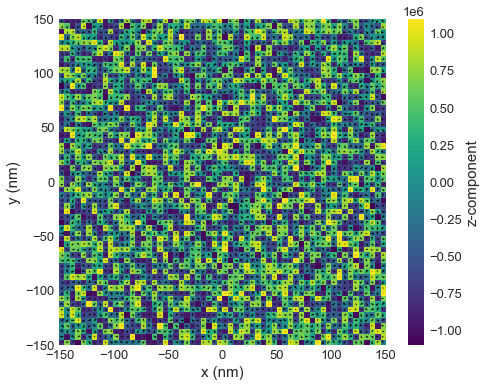

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6  # A/m

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Relax the system and plot its magnetisation.

Running OOMMF (DockerOOMMFRunner) [2021/07/29 11:45]... (17.5 s)


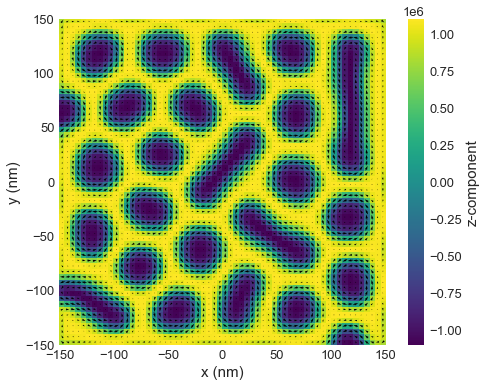

In [2]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

Now we have a magnetisation texture we can compute the LTEM defocus and holography patterns.

## Computing LTEM images

We can use the `mag2exp` package to first calculate the phase of the electrons as they propagate through the sample along the $z$ direction.
The phase shift experienced by the electrons as they travel through the sample due to the magnetic contribution is
\begin{equation} \label{Eq:C7:phase_shift_mag}
    \phi_m (x,y)=-\frac{2\pi e}{h}\int_{-\infty}^\infty A_z (x,y,z)\, {\rm d}z,
\end{equation}
where $h$ is Planck's constant and ${\bf A}$ is the magnetic vector potential, as defined in Ref. \[[Bleaney 2013](https://global.oup.com/academic/product/electricity-and-magnetism-volume-2-9780199645435?cc=gb&lang=en&)\].

The calculation of the phase is performed in Fourier space using
\begin{equation} \label{Eq:C7:FT_M}
    \widetilde{\phi}_m (k_x,k_y)=\frac{i e \mu_0 k_\perp^2}{h} \frac{\left[ \widetilde{\bf M}_I(k_x,k_y)\times {\bf k}_\perp \right] _z}{\left( k_\perp^2 + k_c^2 \right)^2},
\end{equation}
where ${\bf M}_I$ is the integrated magnetisation along the path of the electron beam, $\mu_0$ is the vacuum permeability, and $k$ is the k-vector in Fourier space, as given in Ref \[[Beleggia 2010](https://www.tandfonline.com/doi/abs/10.1080/0141861031000066166)\].
To avoid singularities in Fourier space, a Tikhonov filter is used where $1/k^2$ is replaced by $k^2/(k^2+k_c^2)$ where $k_c$ is the radius of the filter.

The function `mag2exp.ltem_phase` is used to calculate the phase and Fourier transform of the phase. In this function the radius of the Tikhonov filter is defined by `kcx` and `kcy` in units of cell size.

In [3]:
import mag2exp
kcx = kcy = 0.1  # Cell size
phase, ft_phase = mag2exp.ltem.phase(system.m, kcx=kcx, kcy=kcy)

The phase (`phase`) and its Fourier transform (`ft_phase`) are `discretisedfield` objects hence the built in plotting functions can be used to view them. Both the phase and its Fourier transform are complex quantities, hence to view them either the real or imaginary part has to be selected before plotting.

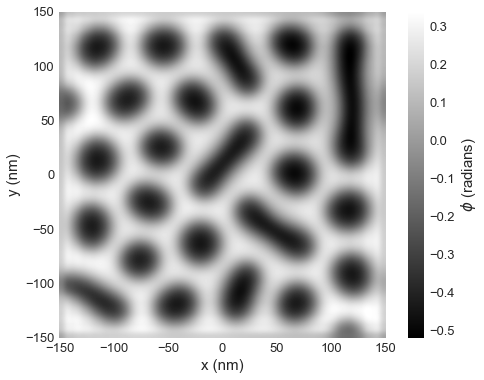

In [4]:
phase.real.mpl.scalar(cmap='gray',
                      interpolation='spline16',
                      colorbar_label=r'$\phi$ (radians)')

Off-axis electron holography the phase of the electrons is recovered directly and may be compared with the phase calculated here.

This example shows how to use the conjugate property to plot $\left\vert\widetilde{\phi}_m\right\vert^2$ with the Tikhonov filter indicated my the small red circle. The `quick_plots` functions, detailed at end of this notebook, can simplify plots like this to a single line. 

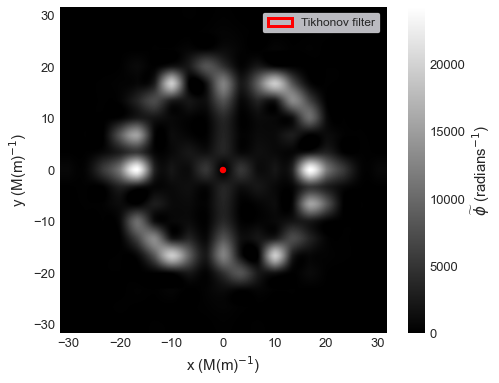

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

centre_region = df.Region(p1=(-30e6, -30e6, 0), p2=(30e6, 30e6, 1))

fig, ax = plt.subplots()
(ft_phase.conjugate * ft_phase)[centre_region].plane('z').real.mpl.scalar(
    ax=ax, cmap='gray', interpolation='spline16', colorbar_label=r'$\widetilde{\phi}$ (radians$^{-1}$)')

multiplier = uu.si_max_multiplier(ft_phase.mesh.region.edges)
ax.add_patch(Ellipse(xy=(0, 0),
                     width=ft_phase.mesh.cell[0] * kcx * 2 / multiplier,
                     height=ft_phase.mesh.cell[1] * kcy * 2 / multiplier,
                     edgecolor='red',
                     facecolor='none',
                     linewidth=3,
                     label='Tikhonov filter'))
ax.legend(frameon=True);

### Defocused Imaging

The wavefunction of the electron beam as it exits the specimen can be calculated using the phase
\begin{equation}
\psi_0 = e^{i\phi_m}.
\end{equation}

Out-of-focus images can be simulated by propagating the wavefunction through free-space by a distance $\Delta f$, known as the defocus, using Contrast Transfer Function $T$ Ref. \[[Bonevich 1994](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.6800)\]

\begin{align}
    \psi_{\Delta f} &= {\psi}_{0} * T, \\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 \widetilde{T}({\bf k}),\\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 e^{2 i \pi k^2 (-\frac{1}{2}\lambda \Delta f + \frac{1}{4} C_s \lambda^3 k^2)}.
\end{align}
$\lambda$ is the relativistic wavelength of the electrons and $C_s$ is the spherical aberration of the electromagnetic lens.

The image at a specific defocus is then given by
\begin{equation} \label{Eq:C7:Intensity}
    I_{\Delta f} = \left\vert\psi_{\Delta f}\right\vert^2.
\end{equation}

The intensity of an in-focus image is $I=\left\vert\psi_0\right\vert^2=1$ and so the image appears featureless however magnetic contrast appears when you go out-of-focus.

The `mag2exp.ltem_defocus_image` function calculates the image at a specific defocus <code>df_length</code>, given the spherical aberration `cs`, and accelerating voltage of the electrons `voltage`.
As an alternative to specifying the accelerating voltage, the wavelength of the electrons `wavelength` can directly be set.

In [6]:
defocus = mag2exp.ltem.defocus_image(phase, voltage=300e3, cs=8000, df_length=-0.4e-3)

The defocus image can then be plot using the inbuilt functions.

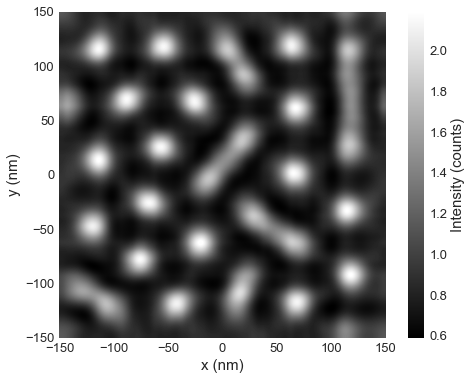

In [7]:
defocus.mpl.scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label='Intensity (counts)')

As a rule of thumb, the magnetic feature will only be seen experimentally using this technique if it gives a contrast greater than 1%. The image contrast is defined as
\begin{equation}
{\rm contrast} = \frac{I_{\rm max}-I_{\rm min}}{I_{\rm max} + I_{\rm min}}
\end{equation}
where $I_{\rm max}$ and $I_{\rm max}$ are, respectively, the maximum and minimum intensities of the image.

In [8]:
contrast = (defocus.array.max() - defocus.array.min()) / (defocus.array.max() + defocus.array.min())
print(f'Contrast: {contrast*100:.1f}%')

Contrast: 57.6%


### Integrated magnetic flux density

From the phase of the electrons determined other useful quantities can be calculated such as the integrated magnetic flux density ${\bf B}_\perp$. This can be used to compare against the results from electron holography, as it calculates the phase and hence ${\bf B}_\perp$ is reconstructed. The ${\bf B}_\perp$ can be calculated Ref. \[[Bleaney 2013](https://global.oup.com/academic/product/electricity-and-magnetism-volume-2-9780199645435?cc=gb&lang=en&)\] from
\begin{equation} \label{Eq:C7:B_perp}
t{\bf B}_\perp =\frac{\Phi_0}{\pi}\begin{pmatrix} -\partial/\partial y \\ \partial/\partial x \end{pmatrix} \phi_m ,
\end{equation}
where $\Phi_0$ is the magnetic flux quantum and $t$ is the thickness of the sample.

In [9]:
imf = mag2exp.ltem.integrated_magnetic_flux_density(phase)

The `mpl.lightness` and `mpl.vector` functions can be used to plot this 2-Dimentional field. Colour plots use the HSV colour map.

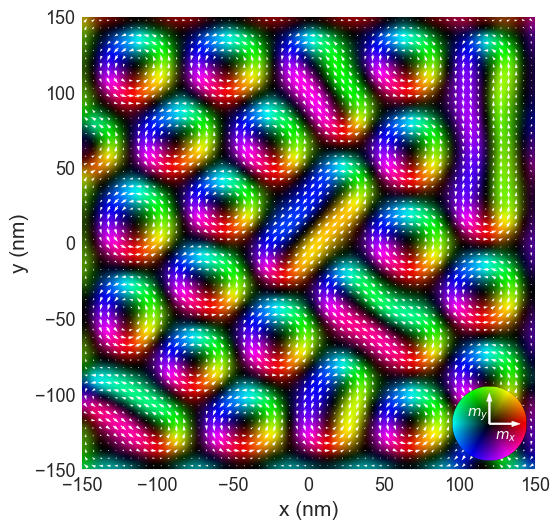

In [10]:
fig, ax = plt.subplots(dpi=100)
imf.mpl.lightness(ax=ax, clim=[0,0.5], interpolation='spline16', colorwheel_args=dict(width=.75, height=.75),
                  colorwheel_xlabel=r'$m_x$', colorwheel_ylabel=r'$m_y$')
imf.mpl.vector(ax=ax, use_color=False, color='w')

`mpl.contour` can be used to plot th contours of a scalar field. The contours of the phase can be plotted, this is also equivalent to the contours for the integrated magnetic flux density.

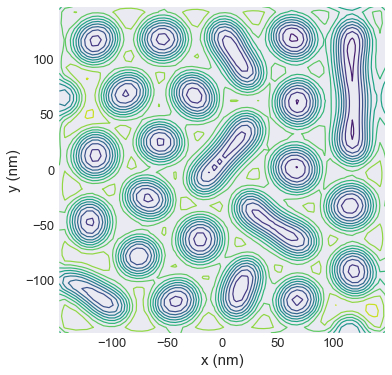

In [11]:
phase.mpl.contour(levels=10, colorbar=False, linewidths=1.2)

## Quick plots

`mag2exp` has an integrated `quick_plots` functionality which is designed to be easy to use and output figures of the desired quantities directly from the magnetisation texture with all the intermediary calculations performed under the hood. These figures are created with set themes by design, and only take arguments relevant to the quantities being calculated.

The phase of the electrons can be plotted using

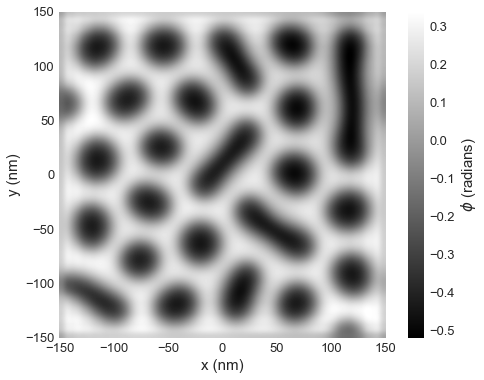

In [12]:
mag2exp.quick_plots.ltem_phase(system.m)

The Fourier transform of the phase of the electrons $\left\vert\widetilde{\phi}_m\right\vert^2$ can be plotted using

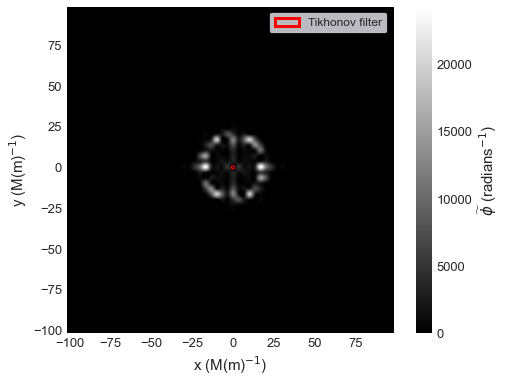

In [13]:
mag2exp.quick_plots.ltem_ft_phase(system.m)

Defocused images can be plotted using

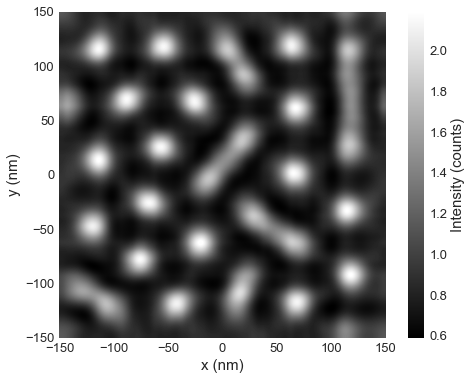

In [14]:
mag2exp.quick_plots.ltem_defocus(system.m, voltage=300e3, cs=8000, df_length=-0.4e-3)

The integrated magnetic flux density can be plotted using

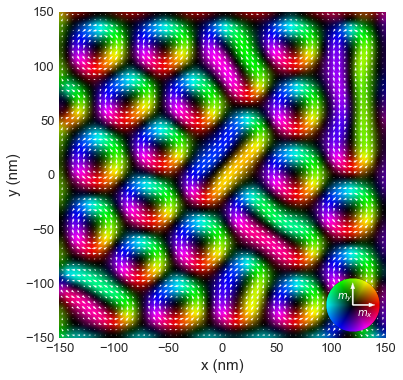

In [15]:
mag2exp.quick_plots.ltem_integrated_mfd(system.m)